# BERTweet with Interweaving Fine-Tuned Approach on Disability and Religion

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [2]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.2 MB/s eta 0:00:00


In [3]:
!pip install -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 16.4 MB/s eta 0:00:00


In [4]:
!pip3 install -q emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import transformers
from transformers import AutoTokenizer,TFRobertaModel

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Functions and Constants

In [7]:
def to_arrays(df):
  X = df['comment_text'].to_numpy()
  y = df['toxicity_binary'].to_numpy()
  return X, y

In [8]:
MAX_SEQUENCE_LENGTH = 128

In [9]:
def tokenizing_pipeline(X, tokenizer):
  bert_tokenized = tokenizer(list(X),
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  bert_inputs = [bert_tokenized.input_ids,
                 bert_tokenized.token_type_ids,
                 bert_tokenized.attention_mask]
  return bert_inputs

def load_data(group):
  df_train = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-train-augmented.csv')
  df_val = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-val-augmented.csv')
  df_test = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-test-augmented.csv')

  return df_train, df_val, df_test

def load_data_as_arr(df_train, df_val, df_test):

  X_train, y_train = to_arrays(df_train)
  X_val, y_val = to_arrays(df_val)
  X_test, y_test = to_arrays(df_test)

  return X_train, y_train, X_test, y_test, X_val, y_val

In [10]:
def build_bertweet_cls_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size=100, 
                          dropout=0.3,
                          learning_rate=0.0001,
                          num_train_layers=0):

    # freeze all pre-trained BERTweet layers
    if num_train_layers == 0:
      bertweet_model.trainable = False

    # partially freeze the first n pre-trained BERTweet layers
    else:
        for layer_num in range(num_train_layers):
            bertweet_model.roberta.encoder.layer[layer_num].trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    # Use the same bertweet model instance
    bert_out = bertweet_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    f1_score = tfa.metrics.F1Score(1, threshold = 0.5)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                                        tf.keras.metrics.Precision(),
                                        tf.keras.metrics.Recall(),
                                        f1_score])

    return classification_model

## Load All Available Data for Disability and Religion

In [11]:
# Disability
disability_train_df, disability_val_df, disability_test_df = load_data('disability')
X_disability_train, y_disability_train, X_disability_test, y_disability_test, X_disability_val, y_disability_val = load_data_as_arr(disability_train_df, disability_val_df, disability_test_df)

# Religion
religion_train_df, religion_val_df, religion_test_df = load_data('religion')
X_religion_train, y_religion_train, X_religion_test, y_religion_test, X_religion_val, y_religion_val = load_data_as_arr(religion_train_df, religion_val_df, religion_test_df)

In [12]:
X_disability_train[1]

' mental disability is extremely physical'

In [13]:
X_disability_train[9]

' There are many different types of disabilities. For example: mental, cognitive, visual, hearing, physical, and speech. Some people physically cannot speak English'

In [14]:
len(X_disability_train)

24904

In [15]:
X_religion_train[0]

' Martin Luther King Jr. and Malcolm X were both killed by violent extremists'

In [16]:
len(X_religion_train)

14811

## Load BERTweet Model from_pretrained()

In [17]:
bertweet_tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base",
                                                    use_fast=False,
                                                    normalization=True,
                                                    add_special_tokens=True,
                                                    return_attention_mask=True)
bertweet_model = TFRobertaModel.from_pretrained("vinai/bertweet-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [18]:
bertweet_model.summary()

Model: "tf_roberta_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 134899968 
 )                                                               
                                                                 
Total params: 134,899,968
Trainable params: 134,899,968
Non-trainable params: 0
_________________________________________________________________


## Tokenize Data Splits

In [19]:
# Disability
bertweet_disability_train_inputs = tokenizing_pipeline(X_disability_train, bertweet_tokenizer)
bertweet_disability_test_inputs = tokenizing_pipeline(X_disability_test, bertweet_tokenizer)
bertweet_disability_val_inputs = tokenizing_pipeline(X_disability_val, bertweet_tokenizer)

# Religion
bertweet_religion_train_inputs = tokenizing_pipeline(X_religion_train, bertweet_tokenizer)
bertweet_religion_test_inputs = tokenizing_pipeline(X_religion_test, bertweet_tokenizer)
bertweet_religion_val_inputs = tokenizing_pipeline(X_religion_val, bertweet_tokenizer)

# Calculate Class Weights for Each Group

Get class weights for disability train set:

In [20]:
neg, pos = np.bincount(y_disability_train)
total = neg + pos
print('Disability Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

disability_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Disability Weight for class 0: {:.2f}'.format(weight_for_0))
print('Disability Weight for class 1: {:.2f}'.format(weight_for_1))

Disability Examples:
    Total: 24904
    Positive: 13009 (52.24% of total)

Disability Weight for class 0: 1.05
Disability Weight for class 1: 0.96


Get class weights for religon train set:

In [21]:
neg, pos = np.bincount(y_religion_train)
total = neg + pos
print('Religion Train Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

religion_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Religion Train Weight for class 0: {:.2f}'.format(weight_for_0))
print('Religion Train Weight for class 1: {:.2f}'.format(weight_for_1))

Religion Train Examples:
    Total: 14811
    Positive: 7560 (51.04% of total)

Religion Train Weight for class 0: 1.02
Religion Train Weight for class 1: 0.98


### Define Hyperparameters for both models

In [22]:
# hyperparameters
batch_size=24
num_train_layers=8
learning_rate=1e-6

# Build Disability Model

In [23]:
disability_model = build_bertweet_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
disability_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                              

# Build Religion Model

In [24]:
religion_model = build_bertweet_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
religion_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                            

# Interweaving Fine-Tuning: Train Disability and Gender Models on ther Respective Data

## Round 1: Train Disability Model for 1 epochs

In [25]:
disability_round1_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 98s 78ms/step - loss: 0.6116 - binary_accuracy: 0.6662 - precision: 0.6699 - recall: 0.7117 - f1_score: 0.6902 - val_loss: 0.4754 - val_binary_accuracy: 0.7717 - val_precision: 0.7912 - val_recall: 0.7603 - val_f1_score: 0.7755


## Round 2: Train Religion Model for 1 epoch

In [26]:
religion_round2_history = religion_model.fit(bertweet_religion_train_inputs,
                                          y_religion_train,
                                          validation_data=(bertweet_religion_val_inputs, y_religion_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=religion_class_weight)

618/618 [==============================] - 68s 84ms/step - loss: 0.5909 - binary_accuracy: 0.6946 - precision_1: 0.7264 - recall_1: 0.6444 - f1_score: 0.6830 - val_loss: 0.4605 - val_binary_accuracy: 0.7971 - val_precision_1: 0.8245 - val_recall_1: 0.7793 - val_f1_score: 0.8013


## Round 3: Train Disability Model for 1 epoch

In [27]:
disability_round3_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 79s 76ms/step - loss: 0.4620 - binary_accuracy: 0.7866 - precision: 0.8070 - recall: 0.7775 - f1_score: 0.7920 - val_loss: 0.4275 - val_binary_accuracy: 0.8023 - val_precision: 0.8252 - val_recall: 0.7850 - val_f1_score: 0.8046


## Round 4: Train Religion Model on for 1 epoch

In [28]:
religion_round4_history = religion_model.fit(bertweet_religion_train_inputs,
                                          y_religion_train,
                                          validation_data=(bertweet_religion_val_inputs, y_religion_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=religion_class_weight)

618/618 [==============================] - 49s 79ms/step - loss: 0.4560 - binary_accuracy: 0.7976 - precision_1: 0.8082 - recall_1: 0.7911 - f1_score: 0.7996 - val_loss: 0.4079 - val_binary_accuracy: 0.8153 - val_precision_1: 0.8437 - val_recall_1: 0.7955 - val_f1_score: 0.8189


## Round 5: Train Disability Model for 1 epoch

In [29]:
disability_round5_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 79s 76ms/step - loss: 0.4341 - binary_accuracy: 0.8030 - precision: 0.8293 - recall: 0.7844 - f1_score: 0.8062 - val_loss: 0.4150 - val_binary_accuracy: 0.8100 - val_precision: 0.8410 - val_recall: 0.7812 - val_f1_score: 0.8100


## Round 6: Train Religion Model for 1 epoch

In [30]:
religion_round6_history = religion_model.fit(bertweet_religion_train_inputs,
                                          y_religion_train,
                                          validation_data=(bertweet_religion_val_inputs, y_religion_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=religion_class_weight)

618/618 [==============================] - 49s 79ms/step - loss: 0.4146 - binary_accuracy: 0.8193 - precision_1: 0.8333 - recall_1: 0.8075 - f1_score: 0.8202 - val_loss: 0.3887 - val_binary_accuracy: 0.8234 - val_precision_1: 0.8457 - val_recall_1: 0.8117 - val_f1_score: 0.8283



## Round 7: Train Disability Model for 1 epoch

In [31]:
disability_round7_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 79s 76ms/step - loss: 0.4147 - binary_accuracy: 0.8149 - precision: 0.8411 - recall: 0.7961 - f1_score: 0.8180 - val_loss: 0.4044 - val_binary_accuracy: 0.8148 - val_precision: 0.8467 - val_recall: 0.7850 - val_f1_score: 0.8147


## Round 8: Train Religion Model for 1 epoch

In [32]:
religion_round8_history = religion_model.fit(bertweet_religion_train_inputs,
                                          y_religion_train,
                                          validation_data=(bertweet_religion_val_inputs, y_religion_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=religion_class_weight)

618/618 [==============================] - 49s 79ms/step - loss: 0.3930 - binary_accuracy: 0.8282 - precision_1: 0.8424 - recall_1: 0.8160 - f1_score: 0.8290 - val_loss: 0.3804 - val_binary_accuracy: 0.8327 - val_precision_1: 0.8546 - val_recall_1: 0.8210 - val_f1_score: 0.8375


## Round 9: Train Disability Model for 1 epoch

In [33]:
disability_round9_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 79s 76ms/step - loss: 0.4028 - binary_accuracy: 0.8210 - precision: 0.8479 - recall: 0.8011 - f1_score: 0.8238 - val_loss: 0.3983 - val_binary_accuracy: 0.8165 - val_precision: 0.8565 - val_recall: 0.7761 - val_f1_score: 0.8143


## Round 10: Train Religion Model for 1 epoch

In [34]:
religion_round10_history = religion_model.fit(bertweet_religion_train_inputs,
                                          y_religion_train,
                                          validation_data=(bertweet_religion_val_inputs, y_religion_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=religion_class_weight)

618/618 [==============================] - 49s 79ms/step - loss: 0.3777 - binary_accuracy: 0.8364 - precision_1: 0.8533 - recall_1: 0.8206 - f1_score: 0.8366 - val_loss: 0.3713 - val_binary_accuracy: 0.8384 - val_precision_1: 0.8474 - val_recall_1: 0.8441 - val_f1_score: 0.8458


## Round 11: Train Disability Model for 1 epoch

In [35]:
disability_round11_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 79s 76ms/step - loss: 0.3938 - binary_accuracy: 0.8259 - precision: 0.8518 - recall: 0.8071 - f1_score: 0.8289 - val_loss: 0.3939 - val_binary_accuracy: 0.8220 - val_precision: 0.8652 - val_recall: 0.7780 - val_f1_score: 0.8193


## Round 12: Train Religion Model for 1 epoch

In [36]:
religion_round12_history = religion_model.fit(bertweet_religion_train_inputs,
                                          y_religion_train,
                                          validation_data=(bertweet_religion_val_inputs, y_religion_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=religion_class_weight)

618/618 [==============================] - 49s 79ms/step - loss: 0.3681 - binary_accuracy: 0.8431 - precision_1: 0.8603 - recall_1: 0.8269 - f1_score: 0.8432 - val_loss: 0.3653 - val_binary_accuracy: 0.8400 - val_precision_1: 0.8517 - val_recall_1: 0.8418 - val_f1_score: 0.8467


## Checkpoint #1: Save Model Weights for Rounds 11 and 12

In [ ]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Religion_Interwoven_disability-checkpt1-rounds_11_12.hdf5')
religion_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Religion_Interwoven_religion-checkpt1-rounds_11_12.hdf5')

## Round 13: Train Disability Model for 1 epoch

In [37]:
disability_round13_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.3860 - binary_accuracy: 0.8293 - precision: 0.8550 - recall: 0.8107 - f1_score: 0.8323 - val_loss: 0.3841 - val_binary_accuracy: 0.8278 - val_precision: 0.8549 - val_recall: 0.8045 - val_f1_score: 0.8289


## Round 14: Train Religion Model on for 1 epoch

In [38]:
religion_round14_history = religion_model.fit(bertweet_religion_train_inputs,
                                          y_religion_train,
                                          validation_data=(bertweet_religion_val_inputs, y_religion_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=religion_class_weight)

618/618 [==============================] - 49s 79ms/step - loss: 0.3566 - binary_accuracy: 0.8485 - precision_1: 0.8652 - recall_1: 0.8329 - f1_score: 0.8488 - val_loss: 0.3625 - val_binary_accuracy: 0.8441 - val_precision_1: 0.8774 - val_recall_1: 0.8171 - val_f1_score: 0.8462


## Checkpoint #2: Save Model Weights for Rounds 13 and 14

In [39]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Religion_Interwoven_disability-checkpt2-rounds_13_14.hdf5')
religion_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Religion_Interwoven_religion-checkpt2-rounds_13_14.hdf5')

## Round 15: Train Disability Model for 1 epoch

In [40]:
disability_round15_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.3770 - binary_accuracy: 0.8323 - precision: 0.8583 - recall: 0.8132 - f1_score: 0.8352 - val_loss: 0.3818 - val_binary_accuracy: 0.8307 - val_precision: 0.8571 - val_recall: 0.8082 - val_f1_score: 0.8319


## Round 16: Train Religion Model on for 1 epoch

In [41]:
religion_round16_history = religion_model.fit(bertweet_religion_train_inputs,
                                          y_religion_train,
                                          validation_data=(bertweet_religion_val_inputs, y_religion_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=religion_class_weight)

618/618 [==============================] - 49s 79ms/step - loss: 0.3500 - binary_accuracy: 0.8533 - precision_1: 0.8682 - recall_1: 0.8401 - f1_score: 0.8539 - val_loss: 0.3562 - val_binary_accuracy: 0.8485 - val_precision_1: 0.8700 - val_recall_1: 0.8364 - val_f1_score: 0.8529


## Checkpoint #3: Save Model Weights for Rounds 15 and 16

In [42]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Religion_Interwoven_disability-checkpt3-rounds_15_16.hdf5')
religion_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Religion_Interwoven_religion-checkpt3-rounds_15_16.hdf5')

## Round 17: Train Disability Model for 1 epoch

In [43]:
disability_round17_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.3712 - binary_accuracy: 0.8361 - precision: 0.8630 - recall: 0.8158 - f1_score: 0.8387 - val_loss: 0.3783 - val_binary_accuracy: 0.8345 - val_precision: 0.8507 - val_recall: 0.8258 - val_f1_score: 0.8381


## Round 18: Train Religion Model for 1 epoch

In [44]:
religion_round18_history = religion_model.fit(bertweet_religion_train_inputs,
                                          y_religion_train,
                                          validation_data=(bertweet_religion_val_inputs, y_religion_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=religion_class_weight)

618/618 [==============================] - 49s 79ms/step - loss: 0.3404 - binary_accuracy: 0.8550 - precision_1: 0.8696 - recall_1: 0.8422 - f1_score: 0.8557 - val_loss: 0.3524 - val_binary_accuracy: 0.8485 - val_precision_1: 0.8736 - val_recall_1: 0.8318 - val_f1_score: 0.8522


# Plots for Disability Model

In [45]:
disability_train_f1_scores = [disability_round1_history.history['f1_score'][0][0], 
                     disability_round3_history.history['f1_score'][0][0],
                     disability_round5_history.history['f1_score'][0][0],
                     disability_round7_history.history['f1_score'][0][0],
                     disability_round9_history.history['f1_score'][0][0],
                     disability_round11_history.history['f1_score'][0][0],
                     disability_round13_history.history['f1_score'][0][0],
                     disability_round15_history.history['f1_score'][0][0],
                     disability_round17_history.history['f1_score'][0][0]]
disability_val_f1_scores = [disability_round1_history.history['val_f1_score'][0][0],
                     disability_round3_history.history['val_f1_score'][0][0],
                     disability_round5_history.history['val_f1_score'][0][0],
                     disability_round7_history.history['val_f1_score'][0][0],
                     disability_round9_history.history['val_f1_score'][0][0],
                     disability_round11_history.history['val_f1_score'][0][0],
                     disability_round13_history.history['val_f1_score'][0][0],
                     disability_round15_history.history['val_f1_score'][0][0],
                     disability_round17_history.history['val_f1_score'][0][0]]
disability_train_loss = [disability_round1_history.history['loss'][0],
                     disability_round3_history.history['loss'][0],
                     disability_round5_history.history['loss'][0],
                     disability_round7_history.history['loss'][0],
                     disability_round9_history.history['loss'][0],
                     disability_round11_history.history['loss'][0],
                     disability_round13_history.history['loss'][0],
                     disability_round15_history.history['loss'][0],
                     disability_round17_history.history['loss'][0]]
disability_val_loss = [disability_round1_history.history['val_loss'][0],
                     disability_round3_history.history['val_loss'][0],
                     disability_round5_history.history['val_loss'][0],
                     disability_round7_history.history['val_loss'][0],
                     disability_round9_history.history['val_loss'][0],
                     disability_round11_history.history['val_loss'][0],
                     disability_round13_history.history['val_loss'][0],
                     disability_round15_history.history['val_loss'][0],
                     disability_round17_history.history['val_loss'][0]]
disability_train_binary_accuracy = [disability_round1_history.history['binary_accuracy'][0],
                     disability_round3_history.history['binary_accuracy'][0],
                     disability_round5_history.history['binary_accuracy'][0],
                     disability_round7_history.history['binary_accuracy'][0],
                     disability_round9_history.history['binary_accuracy'][0],
                     disability_round11_history.history['binary_accuracy'][0],
                     disability_round13_history.history['binary_accuracy'][0],
                     disability_round15_history.history['binary_accuracy'][0],
                     disability_round17_history.history['binary_accuracy'][0]]
disability_val_binary_accuracy = [disability_round1_history.history['val_binary_accuracy'][0],
                     disability_round3_history.history['val_binary_accuracy'][0],
                     disability_round5_history.history['val_binary_accuracy'][0],
                     disability_round7_history.history['val_binary_accuracy'][0],
                     disability_round9_history.history['val_binary_accuracy'][0],
                     disability_round11_history.history['val_binary_accuracy'][0],
                     disability_round13_history.history['val_binary_accuracy'][0],
                     disability_round15_history.history['val_binary_accuracy'][0],
                     disability_round17_history.history['val_binary_accuracy'][0]]

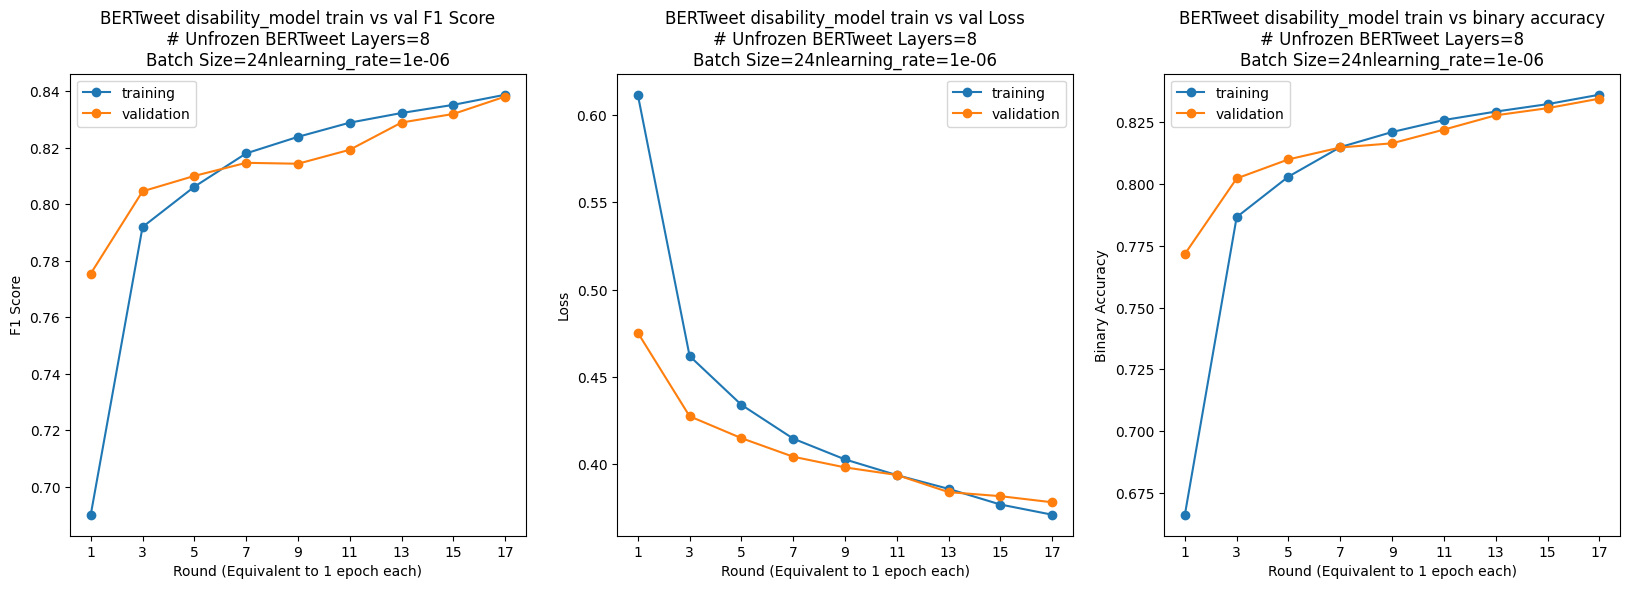

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(disability_train_f1_scores, label="training", marker='o')
axis[0].plot(disability_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[0].set_title('BERTweet disability_model train vs val F1 Score\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(disability_train_loss, label="training", marker='o')
axis[1].plot(disability_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[1].set_title('BERTweet disability_model train vs val Loss\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(disability_train_binary_accuracy, label="training", marker='o')
axis[2].plot(disability_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[2].set_title('BERTweet disability_model train vs binary accuracy\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Plots for Religion Model

In [47]:
religion_train_f1_scores = [religion_round2_history.history['f1_score'][0][0],
                     religion_round4_history.history['f1_score'][0][0],
                     religion_round6_history.history['f1_score'][0][0],
                     religion_round8_history.history['f1_score'][0][0],
                     religion_round10_history.history['f1_score'][0][0],
                     religion_round12_history.history['f1_score'][0][0],
                     religion_round14_history.history['f1_score'][0][0],
                     religion_round16_history.history['f1_score'][0][0],
                     religion_round18_history.history['f1_score'][0][0]]
religion_val_f1_scores = [religion_round2_history.history['val_f1_score'][0][0],
                     religion_round4_history.history['val_f1_score'][0][0],
                     religion_round6_history.history['val_f1_score'][0][0],
                     religion_round8_history.history['val_f1_score'][0][0],
                     religion_round10_history.history['val_f1_score'][0][0],
                     religion_round12_history.history['val_f1_score'][0][0],
                     religion_round14_history.history['val_f1_score'][0][0],
                     religion_round16_history.history['val_f1_score'][0][0],
                     religion_round18_history.history['val_f1_score'][0][0]]
religion_train_loss = [religion_round2_history.history['loss'][0],
                     religion_round4_history.history['loss'][0],
                     religion_round6_history.history['loss'][0],
                     religion_round8_history.history['loss'][0],
                     religion_round10_history.history['loss'][0],
                     religion_round12_history.history['loss'][0],
                     religion_round14_history.history['loss'][0],
                     religion_round16_history.history['loss'][0],
                     religion_round18_history.history['loss'][0]]
religion_val_loss = [religion_round2_history.history['val_loss'][0],
                     religion_round4_history.history['val_loss'][0],
                     religion_round6_history.history['val_loss'][0],
                     religion_round8_history.history['val_loss'][0],
                     religion_round10_history.history['val_loss'][0],
                     religion_round12_history.history['val_loss'][0],
                     religion_round14_history.history['val_loss'][0],
                     religion_round16_history.history['val_loss'][0],
                     religion_round18_history.history['val_loss'][0]]
religion_train_binary_accuracy = [religion_round2_history.history['binary_accuracy'][0],
                     religion_round4_history.history['binary_accuracy'][0],
                     religion_round6_history.history['binary_accuracy'][0],
                     religion_round8_history.history['binary_accuracy'][0],
                     religion_round10_history.history['binary_accuracy'][0],
                     religion_round12_history.history['binary_accuracy'][0],
                     religion_round14_history.history['binary_accuracy'][0],
                     religion_round16_history.history['binary_accuracy'][0],
                     religion_round18_history.history['binary_accuracy'][0]]
religion_val_binary_accuracy = [religion_round2_history.history['val_binary_accuracy'][0],
                     religion_round4_history.history['val_binary_accuracy'][0],
                     religion_round6_history.history['val_binary_accuracy'][0],
                     religion_round8_history.history['val_binary_accuracy'][0],
                     religion_round10_history.history['val_binary_accuracy'][0],
                     religion_round12_history.history['val_binary_accuracy'][0],
                     religion_round14_history.history['val_binary_accuracy'][0],
                     religion_round16_history.history['val_binary_accuracy'][0],
                     religion_round18_history.history['val_binary_accuracy'][0]]


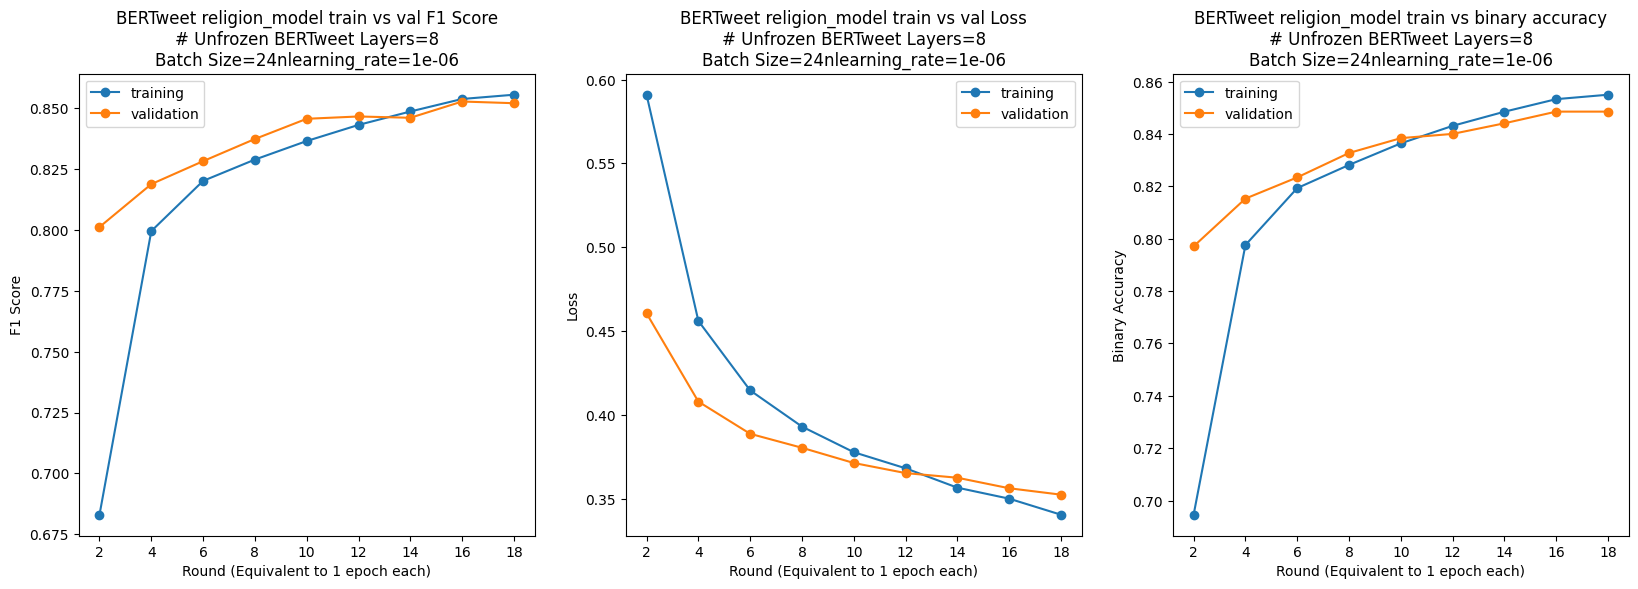

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(religion_train_f1_scores, label="training", marker='o')
axis[0].plot(religion_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[0].set_title('BERTweet religion_model train vs val F1 Score\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(religion_train_loss, label="training", marker='o')
axis[1].plot(religion_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[1].set_title('BERTweet religion_model train vs val Loss\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(religion_train_binary_accuracy, label="training", marker='o')
axis[2].plot(religion_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[2].set_title('BERTweet religion_model train vs binary accuracy\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Save Final Model Weights if Needed

In [ ]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Religion_Interwoven_disability.hdf5')
religion_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Religion_Interwoven_religion.hdf5')

# Keep Previous Results Below/Determine Where to Stop Training
Looking at the train/val curves below, we'll keep the weights from checkpoint #2 at rounds 13 and 14.

DISABILITY MODEL RESULTS

In [57]:
print('disability_train_f1_scores:', disability_train_f1_scores)
print('disability_val_f1_scores:', disability_val_f1_scores)
print('\ndisability_train_loss:', disability_train_loss)
print('disability_val_loss:', disability_val_loss)
print('\ndisability_train_binary_accuracy:', disability_train_binary_accuracy)
print('disability_val_binary_accuracy:', disability_val_binary_accuracy)

disability_train_f1_scores: [0.69017184, 0.79195046, 0.8061941, 0.81799155, 0.823841, 0.8288601, 0.8322746, 0.8351623, 0.8387403]
disability_val_f1_scores: [0.77546185, 0.8045703, 0.8100168, 0.8146541, 0.8143275, 0.81927127, 0.8289065, 0.8319388, 0.8380863]

disability_train_loss: [0.6116281151771545, 0.4620285928249359, 0.4340910017490387, 0.41473329067230225, 0.4028439521789551, 0.39384475350379944, 0.38597872853279114, 0.37701860070228577, 0.37118104100227356]
disability_val_loss: [0.4753905236721039, 0.42754870653152466, 0.4150184690952301, 0.40438976883888245, 0.3982681632041931, 0.39394089579582214, 0.3841155767440796, 0.38180261850357056, 0.37830650806427]

disability_train_binary_accuracy: [0.666198194026947, 0.7866206169128418, 0.8030035495758057, 0.8149293065071106, 0.8210327625274658, 0.8258914351463318, 0.8293045163154602, 0.8323161005973816, 0.8361307382583618]
disability_val_binary_accuracy: [0.7716763019561768, 0.8022639751434326, 0.8099710941314697, 0.8147880434989929, 

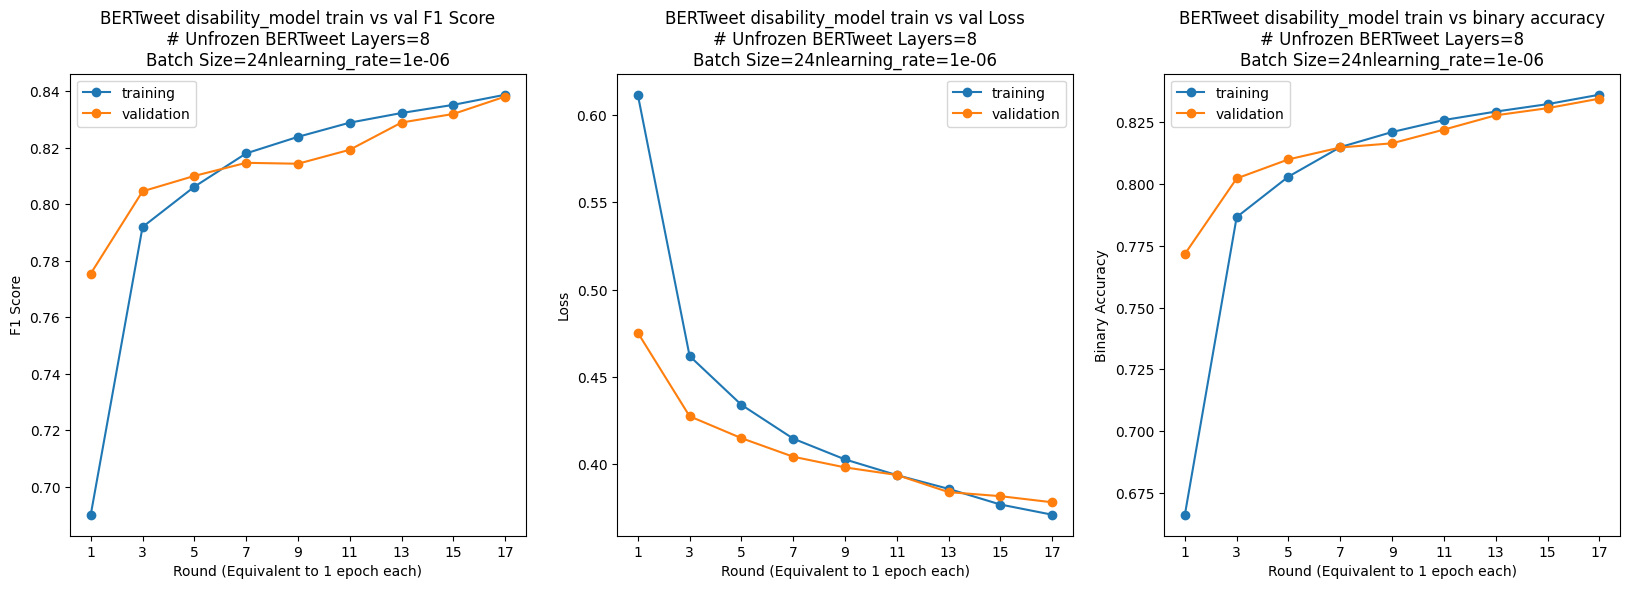

In [46]:
# DISABILITY MODEL PLOTS - DON'T RUN THIS CELL


RELIGION MODEL RESULTS

In [58]:
print('religion_train_f1_scores:', religion_train_f1_scores)
print('religion_val_f1_scores:', religion_val_f1_scores)
print('\nreligion_train_loss:', religion_train_loss)
print('religion_val_loss:', religion_val_loss)
print('\nreligion_train_binary_accuracy:', religion_train_binary_accuracy)
print('religion_val_binary_accuracy:', religion_val_binary_accuracy)

religion_train_f1_scores: [0.6829747, 0.799599, 0.8202338, 0.8289995, 0.836626, 0.84324837, 0.8487667, 0.853916, 0.8556645]
religion_val_f1_scores: [0.8012693, 0.8189039, 0.8283465, 0.8374656, 0.8457674, 0.846721, 0.84618455, 0.8528718, 0.8521739]

religion_train_loss: [0.5909388065338135, 0.45602744817733765, 0.41457661986351013, 0.39299407601356506, 0.37772077322006226, 0.368120014667511, 0.3565625548362732, 0.34999918937683105, 0.34042805433273315]
religion_val_loss: [0.4605283737182617, 0.40789565443992615, 0.3886944651603699, 0.38035857677459717, 0.3712864816188812, 0.3652658462524414, 0.36248862743377686, 0.3562116026878357, 0.35239291191101074]

religion_train_binary_accuracy: [0.6946188807487488, 0.7975828647613525, 0.8193234801292419, 0.8281682729721069, 0.8364053964614868, 0.8430895805358887, 0.8484910130500793, 0.8532847166061401, 0.8549726605415344]
religion_val_binary_accuracy: [0.797083854675293, 0.8153098225593567, 0.8234102725982666, 0.8327258229255676, 0.83839613199234

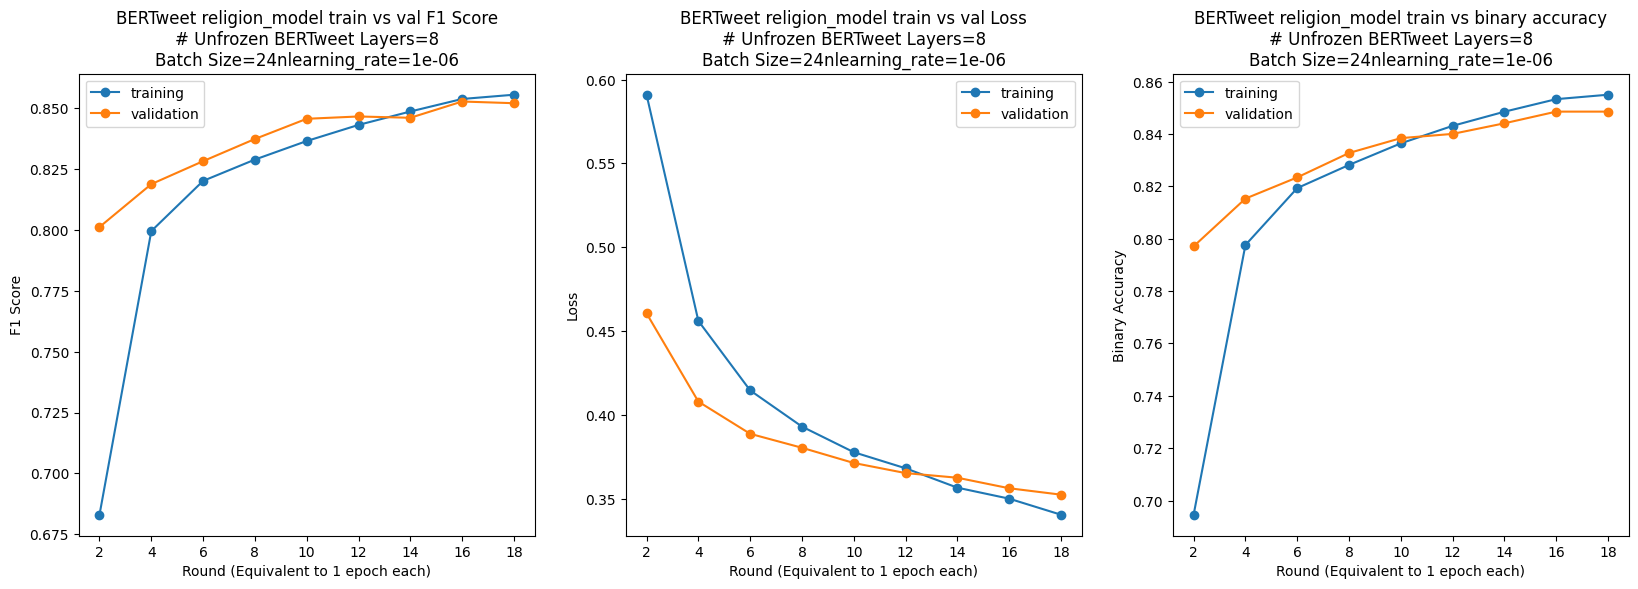

In [48]:
# RELIGION MODEL PLOTS - DON'T RUN THIS CELL